# 学習方法の例

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import *
from sklearn.model_selection import train_test_split
from common.optimizer import *
import pickle
import sklearn.preprocessing as sp
from model import SimpleConvNet, TwoConvNet,DeepConvNet

In [2]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "8"

## データを読む1

In [3]:
raw_data = np.load("../1_data/train_data.npy")
raw_label = np.load("../1_data/train_label.npy")
raw_data = raw_data[:raw_data.shape[0]//1000*1000]
raw_label = raw_label[:raw_label.shape[0]//1000*1000]
print("raw_data.shape=", raw_data.shape)
print("raw_label.shape=", raw_label.shape)
# 正規化
raw_data = (raw_data - raw_data.min()) / raw_data.max()
raw_data = raw_data.astype('float32')

raw_data.shape= (3000, 1, 28, 28)
raw_label.shape= (3000, 15)


In [4]:
train_data = np.load("../1_data/integ_data6.npy")
train_label = np.load("../1_data/integ_label6.npy")
train_data = train_data[:train_data.shape[0]//1000*1000]
train_label = train_label[:train_label.shape[0]//1000*1000]
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

train_data.shape= (30000, 1, 28, 28)
train_label.shape= (30000, 15)


In [5]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (30000, 784)


## trainとtestに分割する

In [15]:
X_train, X_test, y_train, y_test = train_test_split(raw_data, raw_label,test_size=0.3, random_state=1234, shuffle=True)

print(X_train.shape, X_test.shape)

(2100, 1, 28, 28) (900, 1, 28, 28)


In [16]:
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)
train_data = train_data.reshape(-1,1, 28,28)

In [17]:
print(X_train.shape, X_test.shape)

(2100, 1, 28, 28) (900, 1, 28, 28)


## 学習

In [18]:
def save_pickle(i):
    with open("katakana_modeltwo_d50_ep"+str(i)+"_w.pickle", "wb") as f:
        pickle.dump(tnet.params, f)

    c={
        "Batch1":[tnet.layers["Batch1"].moving_mean,tnet.layers["Batch1"].moving_var],
        "Batch2":[tnet.layers["Batch2"].moving_mean,tnet.layers["Batch2"].moving_var],
        "Batch3":[tnet.layers["Batch3"].moving_mean,tnet.layers["Batch3"].moving_var]
    }
    with open("katakana_modeltwo_d50_ep"+str(i)+"_c.pickle", "wb") as f:
        pickle.dump(c, f)

In [19]:
def calc_loss_acc(d,l,model): 
    data_size = len(d)
    batch_size = 100
    minibatch_num = np.ceil( data_size / batch_size).astype(int) 
    li_loss = []
    li_accuracy = []
    li_num = []
    index = np.arange(data_size)
    
    for mn in range(minibatch_num):
        # print(mn)
        mask = index[batch_size*mn:batch_size*(mn+1)]        
        data = d[mask]
        label = l[mask]
        
        loss = model.loss(data, label,train_flg=False)
        accuracy=model.accuracy(data, label,batch_size=batch_size)
        # print(loss, accuracy)
        
        li_loss.append(loss)
        li_accuracy.append(accuracy)
        li_num.append(len(data))

    ave_loss = np.dot(li_loss, li_num) / np.sum(li_num)
    print('loss:', ave_loss)
    ave_accuracy = np.dot(li_accuracy, li_num) / np.sum(li_num)
    print('accuracy:', ave_accuracy)
    return ave_loss,ave_accuracy

In [27]:
tnet = DeepConvNet(input_dim=(1, 28, 28), hidden_size=100, output_size=15, weight_init_std=0.01)


In [11]:
for l in tnet.layers.keys():
    print(l)
print()
for p in tnet.params.keys():
    print(p+"\t "+str(tnet.params[p].shape))

Conv1
Batch1
ReLU1
Conv2
Batch2
ReLU2
Pool1
Affine1
Batch3
ReLU3
Affine2

W1	 (30, 1, 3, 3)
b1	 (30,)
gamma1	 (30,)
beta1	 (30,)
W2	 (30, 30, 3, 3)
b2	 (30,)
gamma2	 (30,)
beta2	 (30,)
W3	 (5880, 100)
b3	 (100,)
gamma3	 (100,)
beta3	 (100,)
W4	 (100, 15)
b4	 (15,)


In [29]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
optimizer = RMSProp(lr=0.01, rho=0.9)
epoch=0

In [30]:
# epochs = 10
batch_size = 100

# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)
# 2層NNのオブジェクト生成


epochs=10
while epoch<epochs:
    print("epoch=%s"%epoch)
    
    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]
    
        # ミニバッチの生成
        x_ = X_train[mask]
        y_ = y_train[mask]
        
        # 勾配の計算
        grads = tnet.gradient(x_, y_)

        # パラメータの更新
        optimizer.update(tnet.params, grads)

    ## 学習経過の記録
    
  
    # 訓練データにおけるloss,acc
    print("###  train  ###")
    loss,acc=calc_loss_acc(X_train,y_train,tnet)
    train_loss.append(loss)
    train_accuracy.append(acc)
    print()
    # テストデータにおけるloss,acc
    print("###  test  ###")
    loss,acc=calc_loss_acc(X_test,y_test,tnet)
    test_loss.append(loss)
    test_accuracy.append(acc)

    
    save_pickle(epoch)
    
    if test_accuracy[-1]==1:
        break
    epoch+=1

epoch=0
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
###  train  ###
loss: 0.46529092951188256
accuracy: 0.8752380952380953

###  test  ###
loss: 0.5088999569509174
accuracy: 0.8566666666666667
epoch=1
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
###  train  ###
loss: 2.271761359004113
accuracy: 0.4742857142857143

###  test  ###


(0, 0.2)

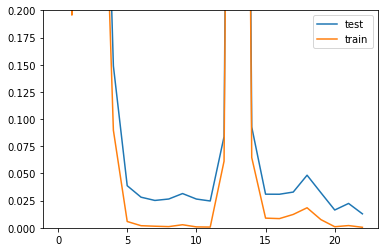

In [52]:
plt.plot(test_loss,label="test")
plt.plot(train_loss,label="train")
plt.legend()
plt.ylim([0,0.2])

(0.95, 1)

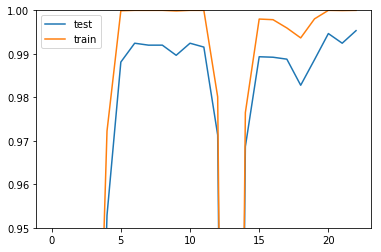

In [53]:
plt.plot(test_accuracy,label="test")
plt.plot(train_accuracy,label="train")
plt.legend()
plt.ylim([0.95,1])

## 学習済みモデルの復元

In [11]:
with open("katakana_modeltwo_d50_ep22_w.pickle", "rb") as f:
    w=pickle.load(f)
with open("katakana_modeltwo_d50_ep22_c.pickle", "rb") as f:
    c=pickle.load(f)

In [12]:
tnet2=TwoConvNet(input_dim=(1, 28, 28),param=w,const=c)

In [ ]:
tnet2.layers["Batch1"].moving_mean

In [13]:
def _check_fail(x,y,t,cnt):
    kana=["a","i","u","e","o","ka","ki","ku","ke","ko","sa","si","su","se","so"]
    for _x,_y,_t in zip(x,y,t):
        __t,__y=np.argmax(_t),np.argmax(_y)
        if __y!=__t:
            cnt+=1
            print("cnt:",cnt,"label:",kana[__t],"pre:",kana[__y])
            plt.imshow(_x[0,:,:],cmap="gray")
            plt.show()
    return cnt

def check_fail(x,t,m):
    index = np.arange(x.shape[0])
    cnt=0
    for i in range(x.shape[0]//1000):
        print("No.",i*1000,"~")
        mask=index[i*1000:(i+1)*1000]
        _x=x[mask]
        _t=t[mask]
        _pre_x=m.predict(_x,train_flg=False)
        cnt=_check_fail(_x,_pre_x,_t,cnt)
        if cnt>100:
            break

No. 0 ~
cnt: 1 label: ku pre: ka


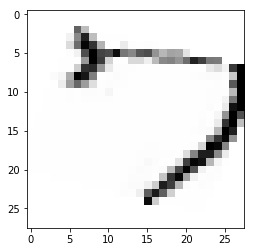

cnt: 2 label: ku pre: ka


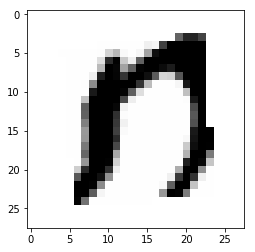

No. 1000 ~
cnt: 3 label: ku pre: ke


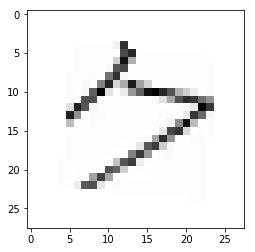

cnt: 4 label: ka pre: sa


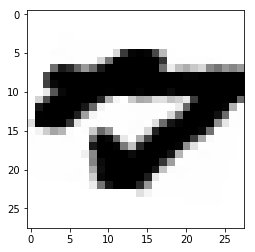

cnt: 5 label: si pre: so


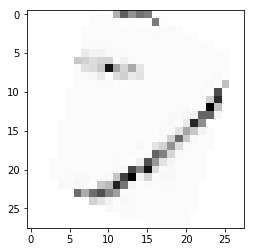

cnt: 6 label: so pre: sa


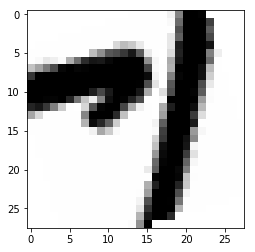

No. 2000 ~
cnt: 7 label: ku pre: ke


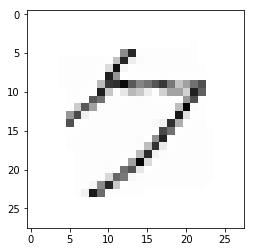

cnt: 8 label: so pre: ke


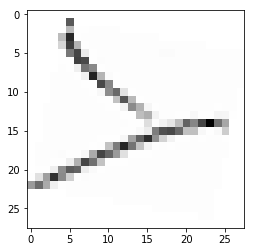

cnt: 9 label: ku pre: ke


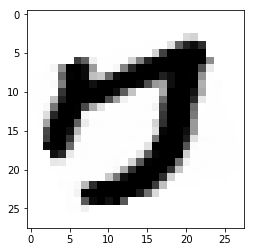

cnt: 10 label: u pre: sa


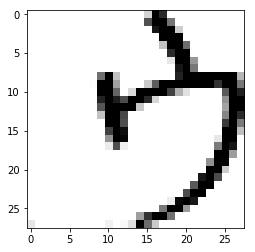

cnt: 11 label: ka pre: sa


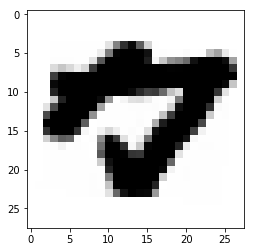

cnt: 12 label: si pre: ki


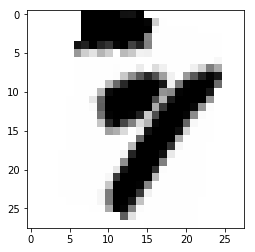

cnt: 13 label: ka pre: sa


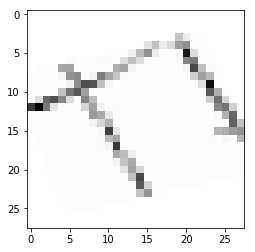

No. 3000 ~
cnt: 14 label: ka pre: ke


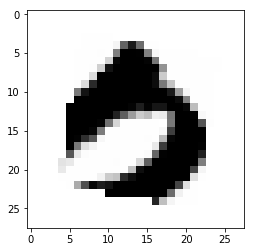

No. 4000 ~
cnt: 15 label: ka pre: ku


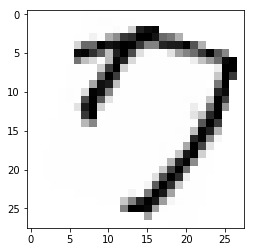

cnt: 16 label: si pre: ke


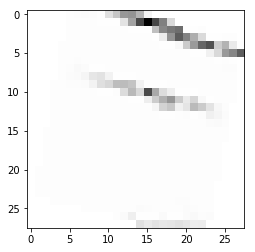

cnt: 17 label: ka pre: sa


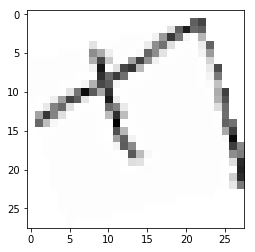

cnt: 18 label: ki pre: su


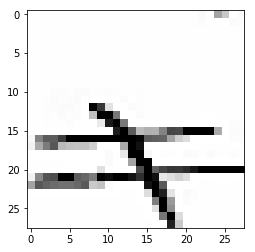

cnt: 19 label: ka pre: i


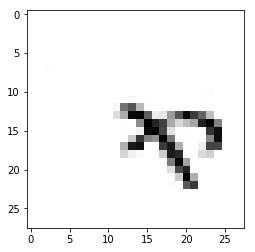

cnt: 20 label: i pre: se


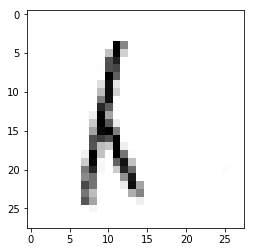

cnt: 21 label: ka pre: o


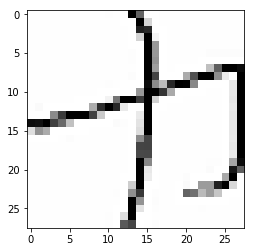

cnt: 22 label: ku pre: ke


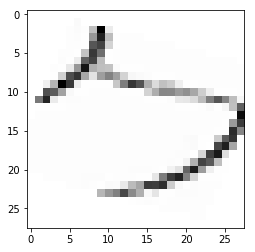

No. 5000 ~
cnt: 23 label: ku pre: ka


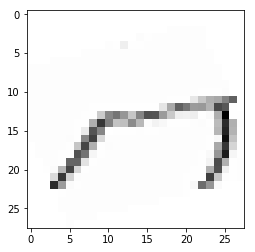

cnt: 24 label: se pre: ka


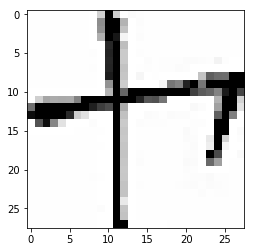

No. 6000 ~
cnt: 25 label: se pre: ki


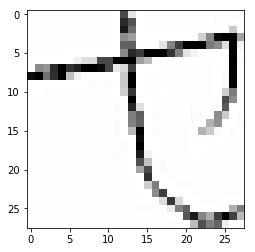

cnt: 26 label: ku pre: u


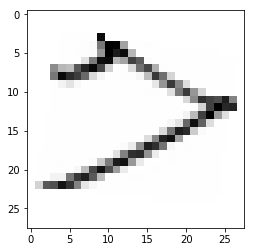

cnt: 27 label: ki pre: o


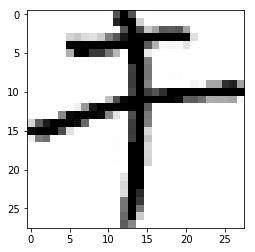

cnt: 28 label: ke pre: ku


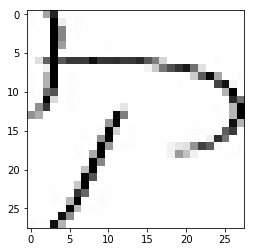

No. 7000 ~
cnt: 29 label: ka pre: se


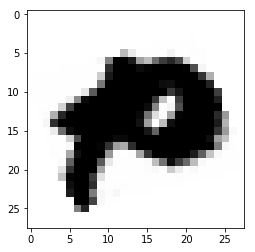

cnt: 30 label: ka pre: ki


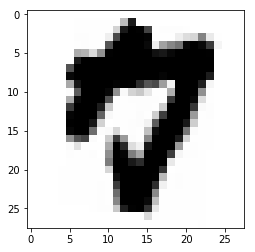

cnt: 31 label: su pre: ku


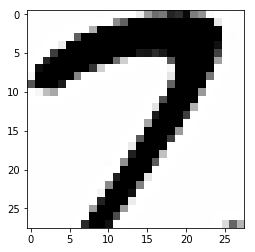

cnt: 32 label: ku pre: ke


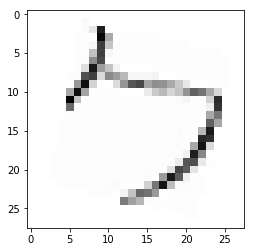

cnt: 33 label: ka pre: ke


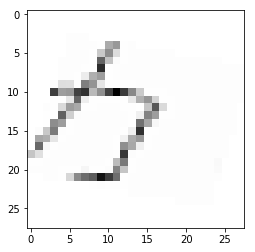

No. 8000 ~
cnt: 34 label: ku pre: ke


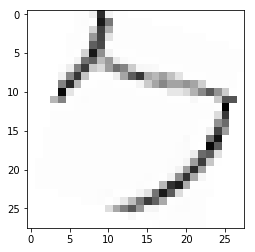

In [14]:
check_fail(X_test,y_test,tnet2)

No. 0 ~
cnt: 1 label: ke pre: ku


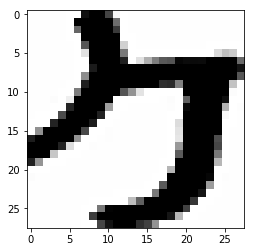

cnt: 2 label: ki pre: o


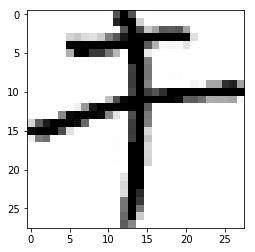

cnt: 3 label: se pre: si


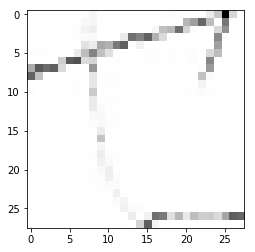

cnt: 4 label: se pre: ka


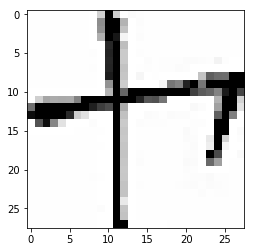

cnt: 5 label: ke pre: ku


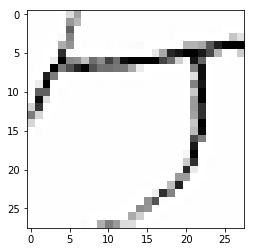

cnt: 6 label: ke pre: ku


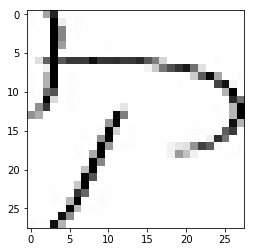

No. 1000 ~
cnt: 7 label: sa pre: ku


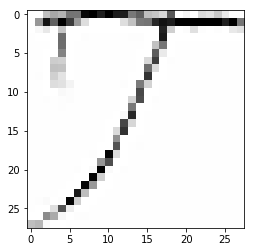

cnt: 8 label: su pre: ku


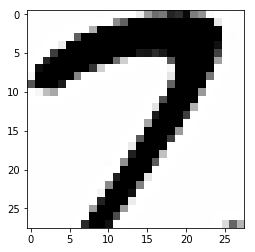

No. 2000 ~
cnt: 9 label: ki pre: su


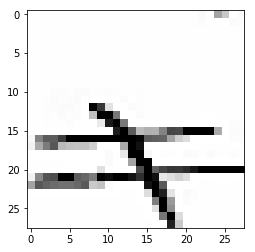

cnt: 10 label: ka pre: ku


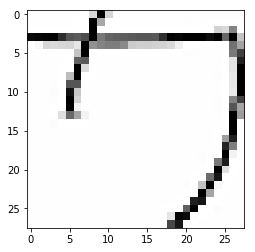

cnt: 11 label: ka pre: o


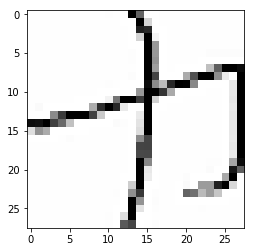

In [55]:
check_fail(raw_data,raw_label,tnet)